In [ ]:
%pip install git+https://github.com/samoturk/mol2vec -q
%pip install 'polars[numpy,pandas,pyarrow]' -q
%pip install rdkit -q
%pip install matplotlib -q
%pip install gdown -q
%pip install scikit_learn -q
%pip install lazypredict_nightly -q
%pip install transformers -q
%pip install ipywidgets -q
%pip install torch_geometric -q

!gdown 1CggX5LuLQ2nRA96SgzMYF3m4Ma7kj1ri -O models/model_300dim.pkl

In [31]:
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt

import numpy as np

from typing import Optional

from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors, AllChem

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from mol2vec.features import (
    mol2alt_sentence,
    MolSentence,
    DfVec,
)
from gensim.models import word2vec

from transformers import AutoTokenizer, AutoModel

def read(n: str, **kwargs):
    return pl.read_csv(f"../data/{n}", **kwargs).to_pandas()


model = word2vec.Word2Vec.load("../models/model_300dim.pkl")
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
bert_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

data = read("smiles/data.csv")
dtf = read("params/data.csv")

# ============================================================================ #
# Fix gensim error
# https://github.com/piskvorky/gensim/commit/ad68ee3f105fc37cf8db333bfb837fe889ff74ac
# ============================================================================ #

scaler = StandardScaler()
selector = SelectKBest(score_func=f_regression, k=100)

In [32]:
def smiles_to_embedding(smiles):
    inputs = tokenizer(smiles, return_tensors="pt", padding=True)
    outputs = bert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].detach().numpy()


def sentence2vec(sentence, model):
    words = sentence.words if hasattr(sentence, "words") else sentence
    vector = np.mean(
        [model.wv[word] for word in words if word in model.wv.key_to_index],
        axis=0,
    )
    return vector


def preprocess(
    data: pd.DataFrame,
) -> tuple[pd.DataFrame, Optional[pd.DataFrame]]:
    data = data.copy()
    data = data.dropna()
    data = data.drop_duplicates()

    def compute_descriptors(smiles: str):
        RDLogger.DisableLog("rdApp.*")
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        sentence = MolSentence(mol2alt_sentence(mol, 1))
        sentences = list(sentence)
        vectors = [
            DfVec(np.array(x)).vec.item() for x in sentence2vec(sentence, model)
        ]
        bert_embedding = smiles_to_embedding(smiles)[0]
        morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        morgan_fp_bits = list(morgan_fp.ToBitString())

        features = {
            "MolWt": Descriptors.MolWt(mol),
            "MolLogP": Descriptors.MolLogP(mol),
            "NumAtoms": mol.GetNumAtoms(),
            "NumHeavyAtoms": mol.GetNumHeavyAtoms(),
            "NumHeteroatoms": Descriptors.NumHeteroatoms(mol),
            "NumRotatableBonds": Descriptors.NumRotatableBonds(mol),
            "NumAromaticRings": Descriptors.NumAromaticRings(mol),
            "NumSaturatedRings": Descriptors.NumSaturatedRings(mol),
            "NumAliphaticRings": Descriptors.NumAliphaticRings(mol),
            "RingCount": Descriptors.RingCount(mol),
            "TPSA": Descriptors.TPSA(mol),
            "LabuteASA": Descriptors.LabuteASA(mol),
            "BalabanJ": Descriptors.BalabanJ(mol),
            "BertzCT": Descriptors.BertzCT(mol),
            "Chi0": Descriptors.Chi0(mol),
            "Chi1": Descriptors.Chi1(mol),
            "Chi0n": Descriptors.Chi0n(mol),
            "Chi1n": Descriptors.Chi1n(mol),
            "Chi2n": Descriptors.Chi2n(mol),
            "Chi3n": Descriptors.Chi3n(mol),
            "Chi4n": Descriptors.Chi4n(mol),
            "HallKierAlpha": Descriptors.HallKierAlpha(mol),
            "Kappa1": Descriptors.Kappa1(mol),
            "Kappa2": Descriptors.Kappa2(mol),
            "Kappa3": Descriptors.Kappa3(mol),
        }

        for i, sen in enumerate(sentences):
            features[f"Sentence_{i}"] = sen

        for i, vec in enumerate(vectors):
            features[f"Vector_{i}"] = vec

        for i, emb in enumerate(bert_embedding):
            features[f"BertEmb_{i}"] = emb

        for i, bit in enumerate(morgan_fp_bits):
            features[f"Bit_{i}"] = bit

        return features

    descriptors_df = pd.DataFrame.from_records(
        data["smiles"].apply(compute_descriptors).dropna().tolist()
    )
    data = pd.concat([descriptors_df, data], axis=1)
    data = data.drop("smiles", axis=1)

    if "blend_id" in data.columns:
        data = data.drop("blend_id", axis=1)

    missing_threshold = 0.1
    missing_percentages = data.isnull().mean()
    columns_to_drop = missing_percentages[
        missing_percentages > missing_threshold
    ].index
    data = data.drop(columns=columns_to_drop)

    data = data.dropna()

    if "oil_property_param_value" in data.columns:
        y = data.pop("oil_property_param_value")
        data = scaler.fit_transform(data, y)
        data = selector.fit_transform(data, y)
        return pd.DataFrame(data), pd.DataFrame(y)

    data = scaler.transform(data)
    data = selector.transform(data)
    return pd.DataFrame(data), None


X, y = preprocess(data)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)
X.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.679355,0.503955,0.065526,-1.236521,0.245488,0.581417,0.171062,0.442626,-0.308750,-1.827533,-0.316779,0.785653,0.179068,-0.814666,-1.554153,0.014457,0.314158,-1.584317,0.626883,0.692637,1.141950,-0.652849,-0.769785,-0.833593,-0.240162,1.193901,-0.309612,-1.537651,-0.101957,0.394745,-1.180219,-0.140805,0.671526,0.717528,0.727720,-0.226268,-0.803786,-0.906760,0.286778,-0.005418,-0.751938,0.107540,-0.558622,0.891654,-0.034454,0.313468,0.965810,-0.679683,-1.063885,-0.615589,0.751591,1.493823,-0.326650,0.089342,-0.109204,1.421974,0.806081,0.711107,0.959299,-1.272107,-0.654220,0.731877,1.131146,0.231652,0.582774,-0.454842,-0.027318,-0.06704,-0.268221,-0.06704,-0.027318,-0.06704,-0.027318,-0.027318,-0.212618,-0.06704,-0.06704,-0.027318,-0.212618,-0.116642,-0.06704,-0.06704,-0.268221,-0.06704,-0.047351,-0.212618,-0.027318,-0.298928,-0.116642,-0.027318,-0.06704,2.828427,-0.027318,-0.488085,-0.06704,-0.212618,-0.027318,-0.038648,-0.06704,-0.027318
1,-0.413933,0.503955,0.065526,0.508318,0.764153,-0.615993,0.545091,1.020633,-0.078331,-0.480799,-1.109796,0.723513,-0.563156,0.124780,-0.626528,-0.588098,0.242003,-0.210319,-0.230043,-0.574043,0.193700,0.743153,-0.313798,-0.779315,1.325406,0.869180,0.196329,-0.985697,0.468008,0.159362,0.307559,-0.288122,0.088130,-0.947459,-0.981364,0.439730,-0.319799,-0.076070,-0.435065,-0.215138,-0.354916,-0.990489,0.186430,-0.935173,-0.789643,-0.508315,-0.350777,-0.532640,0.381953,0.658569,0.158475,-0.493816,0.035305,-0.955570,-0.422654,0.448919,0.462688,-0.594898,-1.036180,-0.285137,-0.671550,-0.106851,-0.067277,0.589924,0.311995,1.072289,-0.027318,-0.06704,-0.268221,-0.06704,-0.027318,-0.06704,-0.027318,-0.027318,-0.212618,-0.06704,-0.06704,-0.027318,-0.212618,-0.116642,-0.06704,-0.06704,-0.268221,-0.06704,-0.047351,-0.212618,-0.027318,-0.298928,-0.116642,-0.027318,-0.06704,-0.353553,-0.027318,-0.488085,-0.06704,-0.212618,-0.027318,-0.038648,-0.06704,-0.027318
2,0.117196,-0.886441,0.065526,1.351473,0.324524,0.307762,-0.331932,-0.673950,0.810510,0.194629,0.547859,-1.121708,-0.124574,0.630402,1.478249,-0.152322,-1.571375,0.965233,-1.340673,0.384487,0.480244,0.072321,1.155750,0.664307,0.463208,-0.719026,-0.880100,0.491582,-0.612047,0.020576,-0.898920,-0.035185,-0.390564,0.025672,-0.241749,-0.441512,0.453091,-0.225554,1.429680,0.581929,-0.049323,0.073243,-0.037200,-0.570253,1.016014,-0.040704,-1.459076,-0.450366,-0.743090,0.460107,0.246372,0.339572,1.189830,-0.120370,-0.275321,-0.048528,-0.844102,-0.193084,0.317915,0.102930,1.407909,-1.075276,-0.838201,-0.181031,-0.215489,-0.962572,-0.027318,-0.06704,-0.268221,-0.06704,-0.027318,-0.06704,-0.027318,-0.027318,-0.212618,-0.06704,-0.06704,-0.027318,-0.212618,-0.116642,-0.06704,-0.06704,-0.268221,-0.06704,-0.047351,-0.212618,-0.027318,-0.298928,-0.116642,-0.027318,-0.06704,-0.353553,-0.027318,-0.488085,-0.06704,-0.212618,-0.027318,-0.038648,-0.06704,-0.027318


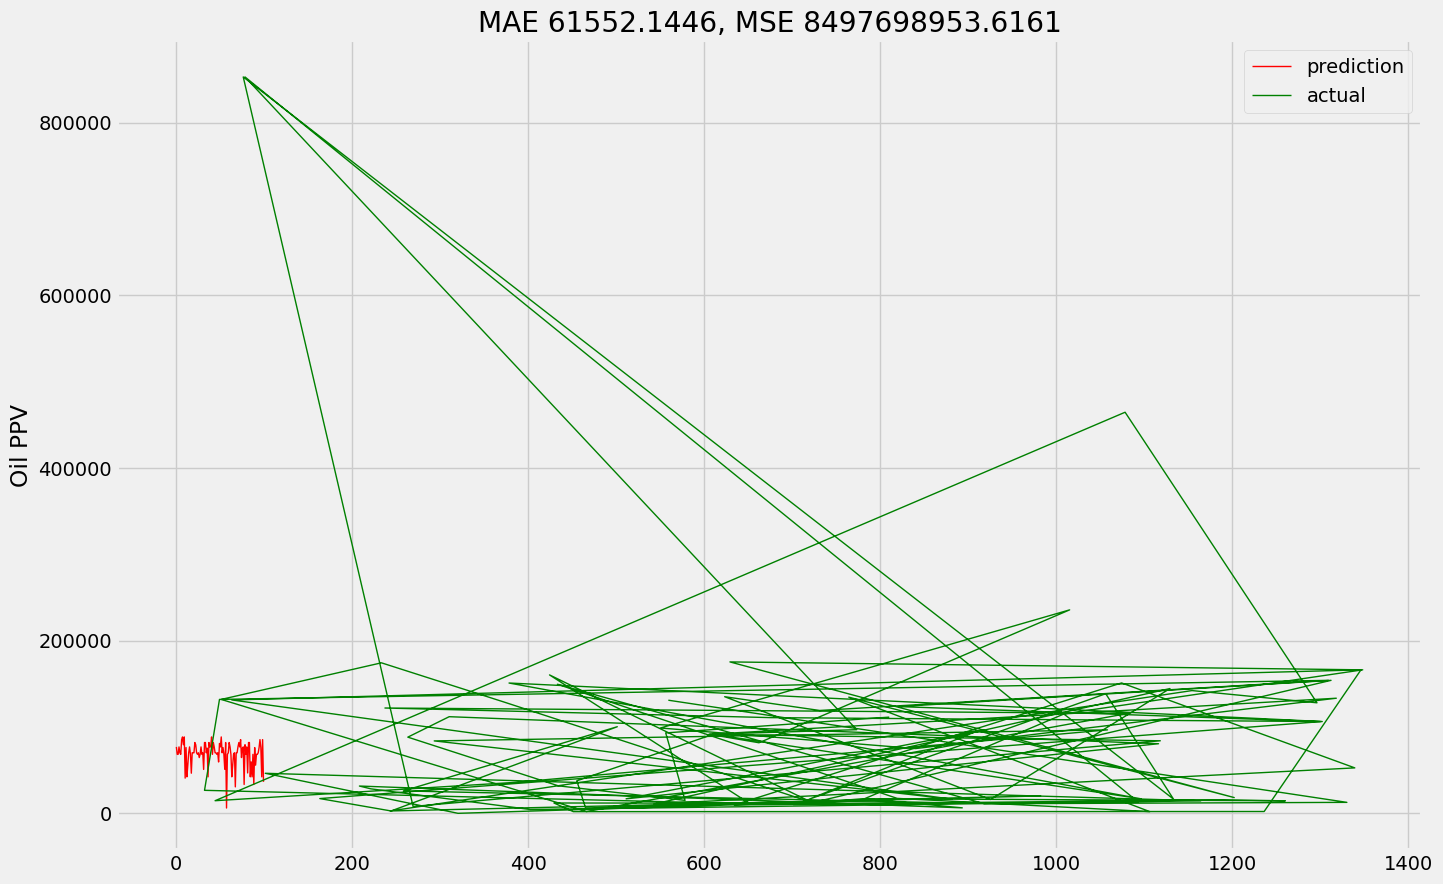

MAE score: 61552.1446
MSE score: 8497698953.6161


In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import RidgeCV


def evaluation(model, X_test, y_test):
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)

    plt.figure(figsize=(15, 10))
    plt.plot(prediction[:100], "red", label="prediction", linewidth=1.0)
    plt.plot(y_test[:100], "green", label="actual", linewidth=1.0)
    plt.legend()
    plt.ylabel("Oil PPV")
    plt.title("MAE {}, MSE {}".format(round(mae, 4), round(mse, 4)))
    plt.show()

    print("MAE score:", round(mae, 4))
    print("MSE score:", round(mse, 4))


ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
evaluation(ridge, X_test, y_test)
# MAE score: 56469.4379
# MAE score: 59987.7663

In [ ]:
from sklearn.metrics import mean_absolute_error  # noqa: F811
from lazypredict import LazyRegressor

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

X_train = X_train.squeeze()
X_test = X_test.squeeze()
y_train = y_train.squeeze()
y_test = y_test.squeeze()

reg = LazyRegressor(predictions=True, custom_metric=mae)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
models.sort_values(by="mae", ascending=True).head(5)